# Week7. CNN


本周实验课，我们将首先进一步学习通过Dataset与Dataloader对数据进行预处理、读取与加载操作。然后我们将学习如何编程实现ResNet残差网络的搭建。

本周将有一个在课堂上完成的实验以及两个课下的小作业需要提交。提交作业时需要在本ipynb文件上完成作业，并将本文件夹打包成压缩包并提交，压缩包命名为week7_姓名_学号.zip。本周由TA_汪思达以及TA_胡仰文负责，如果遇到任何问题请在课程微信群中@TA_汪思达。


# 数据预处理、读取、加载

在week4中，我们简单介绍了Dataset与Dataloader的功能与用法（二者都在torch.utils.data中）。这一部分，我们将继续介绍如何通过Dataset与Dataloader对数据进行预处理、读取与加载。之后，我们假定一个情境，让大家动手操作，熟悉对原始数据的预处理以及自定义Dataset实现所需功能。

## Dataset

Dataset用于读取数据集，所有数据集类都继承于它。对于数据集的读取，可分为使用官方实现的接口或自己实现两种方法，下面我们简单梳理一下这两种方式。

（1）使用官方接口

torchvision.datasets提供了计算机视觉一些常用数据集的读取，这些接口通常有root、train、transform、download等参数，大家在前面的实验课中已经了解这些参数的含义与用法。此外，当图片数据按照这种格式组织——同一类的图片放在同一文件夹，不同类别的文件夹放同一目录层级时，可以使用torchvision.datasets.ImageFolder较灵活地读取，这个接口会自动帮你生成图片标签。

（2）自己实现

使用官方的数据集读取虽然方便，但在面对一个新任务时，我们很可能需要自己写一个继承Dataset的类去读取数据集，比如当我们
* 需要在init中读取特定形式的数据，或者想传入一些自定义参数以对数据集做不同处理
* 想让getitem函数返回的不是(img, label)的元组，而是其他数据组织形式

自定义数据集类并不复杂，需要继承Dataset类需要完成init、getitem、len三个函数，week4中我们也已了解过。定义完数据集类之后，我们需要Dataloader在这个基础上产生多个batch。

## Dataloader

dataloader提供了一个数据加载的方法，下面我们基于源码注释分析它的主要参数。dataloader主要有以下参数：
* dataset，数据集类的实例化对象
* batch_size，每批样本的数量
* shuffle，是否打乱数据
* sampler，定义取标签的策略，也就是产生一组index。当指定sampler时，shuffle必须为False
* batch_sampler，产生每个batch的index。当指定batch_sampler时，不能指定batch_size、shuffle、sampler、drop_last
* num_workers，用几个进程去读取数据，0代表由主进程处理，default:0
* collect_fn，一个函数，把多个数据打包成一个batch
* pin_memory，如果为True，返回数据前loader会将数据拷贝在CUDA固定位置上，default:False
* drop_last，如果数据总数不能被batch_size整除，是否丢弃最后一批，default:False

### sampler、shuffle、dropout_last、batch_size与batch_sampler

这几个参数关系比较密切，他们的目的是生成每个batch的index（后续再根据这些index去数据集中取出数据，组成一个batch），主要注意以下几点：

1、torch.utils.data.sampler中定义了四种sampler
* SequentialSampler，用于顺序读取
* RandomSampler，用于乱序读取
* SubsetRandomSampler，打乱传入的index
* WeightedRandomSampler，与RandomSampler类似，但可以指定采样权重

2、sampler与shuffle参数的关系为：在用户不指定sampler的前提下，若shuffle=True，使用RandomSampler，否则使用SequentialSampler。一种常用的方式是，训练集shuffle=True，测试集shuffle=False。

3、如果batch_sampler不是用户指定的，那么它将通过sampler、dropout_last和batch_size三个参数自动生成。


In [1]:
from torch.utils.data import SequentialSampler, RandomSampler, SubsetRandomSampler, WeightedRandomSampler, BatchSampler

print(list(SequentialSampler(data_source=[0]*10))) 
print(list(RandomSampler(data_source=[0]*10)))
print(list(SubsetRandomSampler(indices=[1, 8, 10, 13, 15, 20])))
print(list(WeightedRandomSampler(weights=[1, 1, 1, 5, 5], num_samples=10, replacement=True)))
print(list(BatchSampler(SequentialSampler([0]*10), batch_size=3, drop_last=False)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[4, 7, 3, 1, 2, 0, 5, 6, 9, 8]
[13, 8, 15, 20, 1, 10]
[4, 3, 2, 3, 3, 3, 4, 3, 3, 4]
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]


一般情况下，我们使用dataloader时较常用的参数（除dataset与batch_size）有shuffle、num_workers、pin_memory，对于上面介绍的其余参数有需要更改的情况吗？
* sampler，需要使用除内置四种sampler外的其他index产生方式
* collect_fn，如果dataset的数据有某一项在维度上不一致，那么需要重写collect_fn

对于Dataloader更加详细的分析可以阅读[这里](https://blog.csdn.net/g11d111/article/details/81504637)，或者访问[这里](https://zhuanlan.zhihu.com/p/76893455)获取比较简洁的介绍。

综合上面两个部分，可以发现
1. Dataset提供了数据集、如何通过一个index获取数据项的方法、数据集长度这几个信息
2. 在此基础上，Dataloader在用户不指定sampler时，根据shuffle参数与Dataset的数据长度，生成了一个定义所有index序列的sampler
3. 接下来，通过sampler、drop_last、batch_size这三个参数得到了batch_sampler，它用于产生每个batch的index
4. 之后再通过collect_fn将这些index对应的Dataset数据打包成一个batch
5. 此外，Dataloader提供num_workers、pin_memory参数让用户在资源允许的情况下加快数据加载

至此，通过Dataset与Dataloader，我们完成对数据的读取与加载，将数据划分成了多个mini-batch。

## homework

现在我们假定一个实际项目中的情境：你拿到了一批数据与一个说明其对应label的csv文件，你希望根据这批数据中的某些类别(类别个数$\ge$2)训练模型并评估。为此你需要将数据划分为训练集、验证集与测试集。此外，你需要写一个继承Dataset的CustomDataset类以读入数据，形式为CustomDataset(root, mode, target_classes, transform)，参数解释如下：
* root：文件路径
* mode：选择模式，是"train"、"val"、"test"三者之一
* target_classes：用于训练的类别，以列表形式传入，比如[0, 1, 2]表示取第0、1、2类的数据
* transform：对图像的transform

说明：
* 这是一个假定情境，目的是让大家熟悉基础的数据预处理、数据读取与产生标签的过程，在实际项目中对于Dataset的实现要具体问题具体分析
* 在文件夹original_data中，文件夹imgs存放着图片数据，ground_truth.csv存放着图片所对应的标签
* 处理完数据并写完读取数据的类即可，不用训练模型。你可以设置不同参数，查看这些语句的输出是否与期望输出一致：

In [62]:
import os
from PIL import Image # PyTorch's transform needs to read PIL images
import numpy as np
import pandas as pd
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

class CustomDataset(data.Dataset):
    """
    My own dataset
    """
    def __init__(self, root=".", mode="train", target_classes=[0,1,2,3], transform=transforms.ToTensor()):
        # notice transforms.ToTensor() will change the scale of the figure to [0,1]
        data = pd.read_csv(os.path.join(root,"ground_truth.csv"))
        target_classes = list(map(lambda x: "class_"+str(x),target_classes))
        data = data[(data[target_classes] == 1).any(axis=1)]
        files = data["image"].to_numpy()
        n = len(files)
        data.insert(1,"target",np.zeros(n,dtype=np.int))
        for i,class_name in enumerate(target_classes):
            data.loc[data[class_name] == 1,"target"] = i # relabeling
        # easy threshold separation
        if mode == "train": # 60%
            threshold_a = 0
            threshold_b = int(0.6*n)
        elif mode == "val": # 20%
            threshold_a = int(0.6*n)
            threshold_b = int(0.8*n)
        else: # test 20%
            threshold_a = int(0.8*n)
            threshold_b = n
        files = files[threshold_a:threshold_b]
        self.inputs = []
        for img in files:
            self.inputs.append(Image.open(os.path.join(root,"images",img+".png")))
        self.inputs = self.inputs
        self.targets = data["target"][threshold_a:threshold_b].to_numpy()
        self.transform = transform
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        """
        Generate ONE sample of the data
        """
        return self.transform(self.inputs[idx]), self.targets[idx]

dataset = CustomDataset("original_data","train",[1,2]) # 自己定义参数
print(dataset.__len__()) # 查看数据的长度
print(dataset.__getitem__(10)) # 查看某一项数据，比如index=10

loader = DataLoader(dataset, shuffle=False, batch_size=5)
print(next(iter(loader))) # 产生一个batch

300
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

提示：
* 使用csv或pandas包读取ground_truth.csv
* 在不同mode与target_classes的情况下，注意len函数返回的长度是否正确，这将影响到Dataloader能否正确加载
* 产生标签时，从0开始编号。e.g.选取第一类和第三类，产生的label应为0和1，而不是1和3

# 搭建ResNet网络

之前的理论课上，我们已经学习过ResNet残差网络。这次我们将通过自己的力量搭建出ResNet网络进行CIFAR-10分类任务的训练。


## 准备数据

之前我们已经学习过数据集和数据加载器如何实现，此处不再过多介绍，该部分代码如下： 

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms

# mean and std of cifar10 in 3 channels 
cifar10_mean = (0.49, 0.48, 0.45)
cifar10_std = (0.25, 0.24, 0.26)

# define transform operations of train dataset 
train_transform = transforms.Compose([
    # data augmentation
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)])

# mini train Cifar10 datasets: 1000 images each class
train_dataset = torchvision.datasets.ImageFolder(root='./data/path2cifar10/train', transform=train_transform)
# mini test Cifar10 datasets: 500 images each class
test_dataset = torchvision.datasets.ImageFolder(root='./data/path2cifar10/test', transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           num_workers = 4,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          num_workers = 4,
                                          shuffle=False)

## 构建残差块

残差块（Residual Block）是ResNet最重要的创新部分，也是ResNet相比于其之前所有网络结构性能提升的关键所在。残差块通过引入Skip Connection到CNN网络结构中，有效地缓解了之前CNN结构无法解决的网络退化的问题，使得我们可以训练更深的神经网路，并且在性能上也有明显的提升。下图为ResNet18中残差块的结构：


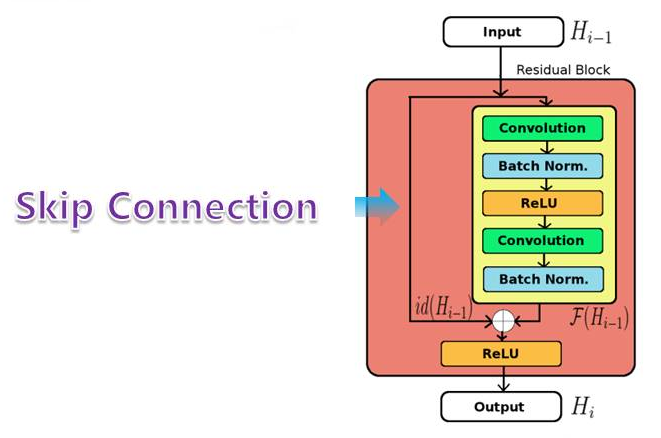

之前的实验课上我们已经学过如何通过PyTorch中完成CNN模型的设计与实现。如果对之前的内容还不清楚可以参考下方代码：

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initializes internal Module state, shared by nn.Module.
        """
        super(CNN_Block, self).__init__()   # 调用父类的构造函数
        self.conv = nn.Conv2d(in_channels, out_channels, stride)   
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):   
        """
        Defines the computation performed at every call.
        x: N * C * H * W
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

请大家根据所学知识:

1.在下面代码中构建如上图中ResNet18残差块的_init_函数（卷积核大小(kernel_size)为3*3）：

2.相比于传统卷积网络的网络块，残差块引入了skip connection结构如上图所示，请在下面代码中构建如上图中ResNet18残差块的forward函数：

In [100]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Initializes internal Module state, shared by both nn.Module.
        """
        #To-Do:add code here
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels) # stride=1
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample #我们在两次卷积中可能会使输入的tensor的size与输出的tensor的size不相等,
                                                             #为了使它们能够相加,所以输出的tensor与输入的tensor size不同时,
                                                             #我们使用downsample(由外部传入)来使保持size相同
                
    def forward(self, x):
        """
        Defines the computation performed at every call.
        x: N * C * H * W
        """
        #To-Do: add code here
        x_in = x
        
        # if the size of input x changes, using downsample to change the size of residual
        if self.downsample:
            x_in = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out,inplace=True)

        out = self.conv2(out)
        out = self.bn2(out)

        out = out + x_in # key
        out = F.relu(out,inplace=True)

        return out
   

## ResNet网络模型搭建

ResNet网络模型可分为三个部分：

1.第一层降采样卷积

2.由多个残差块构建形成的残差模块

3.全局平均池化层和全连接层

以ResNet18为例，其网络模型结构如下图所示：

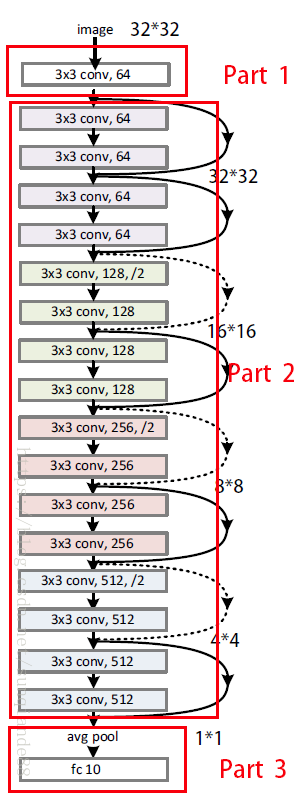

请大家在下面代码中完成对于ResNet网络结构第一部分与第三部分的补充，第二部分将在大家完成补充后与第一、第三部分合在一起进行讲解。

In [103]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        """
        Initializes internal Module state, shared by both nn.Module and ScriptModule.
        """
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        #part1
        #To-Do:intialize part 1 here
        self.conv1 = conv3x3(3, self.in_channels, stride=1)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        #part2 
        self.layer1 = self.make_layer(block, 64, num_blocks=layers[0])
        self.layer2 = self.make_layer(block, 128, num_blocks=layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks=layers[2], stride=2) #To-Do: complete defination of self.layer3
        self.layer4 = self.make_layer(block, 512, num_blocks=layers[3], stride=2)
        
        #part3
        #To-Do: initialize part 3 here
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        """
        make a layer with num_blocks blocks.
        """
        
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            # use Conv2d with stride to downsample
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        # first block with downsample
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        
        self.in_channels = out_channels
        # add num_blocks - 1 blocks
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        # return a layer containing layers
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Defines the computation performed at every call.
        """
        #To-Do: define the computation of  ResNet
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out,inplace=True)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
    
        # view: here change output size from 4 dimensions to 2 dimensions
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [104]:
resnet = ResNet(ResidualBlock, [2, 2, 2, 2])  #ResNet18
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## 训练模型

之前的学习中已学习过如何训练神经网络模型，此处不再进行过多讲解。同学们可以通过如下代码调用fit函数进行网络模型的训练，并观察训练结果。

In [87]:
def train(model, train_loader, loss_func, optimizer, device):
    """
    train model using loss_fn and optimizer in an epoch.
    model: CNN networks
    train_loader: a Dataloader object with training data
    loss_func: loss function
    device: train on cpu or gpu device
    """
    total_loss = 0
    # train the model using minibatch
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)

        # forward
        outputs = model(images)
        loss = loss_func(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # every 100 iteration, print loss
        if (i + 1) % 100 == 0:
            print ("Step [{}/{}] Train Loss: {:.4f}"
                   .format(i+1, len(train_loader), loss.item()))
    return total_loss / len(train_loader)

In [72]:
def evaluate(model, val_loader, device):
    """
    model: CNN networks
    val_loader: a Dataloader object with validation data
    device: evaluate on cpu or gpu device
    return classification accuracy of the model on val dataset
    """
    # evaluate the model
    model.eval()
    # context-manager that disabled gradient computation
    with torch.no_grad():
        correct = 0
        total = 0
        
        for i, (images, targets) in enumerate(val_loader):
            # device: cpu or gpu
            images = images.to(device)
            targets = targets.to(device)
            
            
            outputs = model(images)
            
            # return the maximum value of each row of the input tensor in the 
            # given dimension dim, the second return vale is the index location
            # of each maxium value found(argmax)
            _, predicted = torch.max(outputs.data, dim=1)
            
            
            correct += (predicted == targets).sum().item()
            
            total += targets.size(0)
            
        accuracy = correct / total
        print('Accuracy on Test Set: {:.4f} %'.format(100 * accuracy))
        return accuracy

In [88]:
def save_model(model, save_path):
    # save model
    torch.save(model.state_dict(), save_path)

In [89]:
import matplotlib.pyplot as plt

def show_curve(ys, title):
    """
    plot curlve for Loss and Accuacy
    Args:
        ys: loss or acc list
        title: loss or accuracy
    """
    x = np.array(range(len(ys)))
    y = np.array(ys)
    plt.plot(x, y, c='b')
    plt.axis()
    plt.title('{} curve'.format(title))
    plt.xlabel('epoch')
    plt.ylabel('{}'.format(title))
    plt.show()

In [79]:
def fit(model, num_epochs, optimizer, device):
    """
     train and evaluate an classifier num_epochs times.
    n and evaluate an classifier num_epochs times.
    We use optimizer and cross entropy loss to train the model. 
    Args: 
        model: CNN network
        num_epochs: the number of training epochs
        optimizer: optimize the loss function    loss_func.to(device)
    loss_func.to(device)

    """
        
    # loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    # log train loss and test accuracy
    losses = []
    accs = []
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}:'.format(epoch + 1, num_epochs))
        # train step
        loss = train(model, train_loader, loss_func, optimizer, device)
        losses.append(loss)
        
        # evaluate step
        accuracy = evaluate(model, test_loader, device)
        accs.append(accuracy)
        
    
    # show curve
    show_curve(losses, "train loss")
    show_curve(accs, "test accuracy")

Epoch 1/10:
Step [100/100] Train Loss: 1.7041
Accuracy on Test Set: 30.5400 %
Epoch 2/10:
Step [100/100] Train Loss: 1.9460
Accuracy on Test Set: 27.8200 %
Epoch 3/10:
Step [100/100] Train Loss: 1.9228
Accuracy on Test Set: 36.0200 %
Epoch 4/10:
Step [100/100] Train Loss: 1.8259
Accuracy on Test Set: 38.2000 %
Epoch 5/10:
Step [100/100] Train Loss: 1.4863
Accuracy on Test Set: 41.3600 %
Epoch 6/10:
Step [100/100] Train Loss: 1.4587
Accuracy on Test Set: 42.3200 %
Epoch 7/10:
Step [100/100] Train Loss: 1.5375
Accuracy on Test Set: 45.5400 %
Epoch 8/10:
Step [100/100] Train Loss: 1.5649
Accuracy on Test Set: 46.1400 %
Epoch 9/10:
Step [100/100] Train Loss: 1.3678
Accuracy on Test Set: 50.8600 %
Epoch 10/10:
Step [100/100] Train Loss: 1.2671
Accuracy on Test Set: 49.7800 %


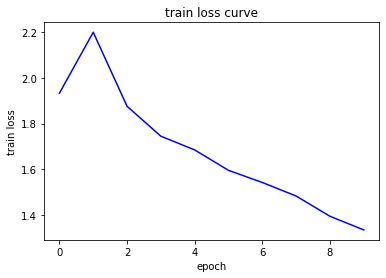

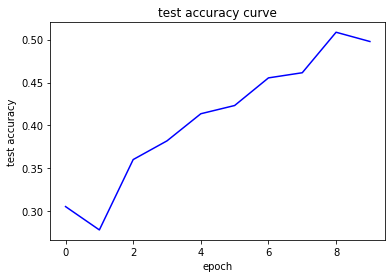

In [105]:
# Hyper-parameters
num_epochs = 10
lr = 0.001
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=lr)

fit(resnet, num_epochs, optimizer, device)

## homework

下图表示将SE模块嵌入到ResNet的残差模块：


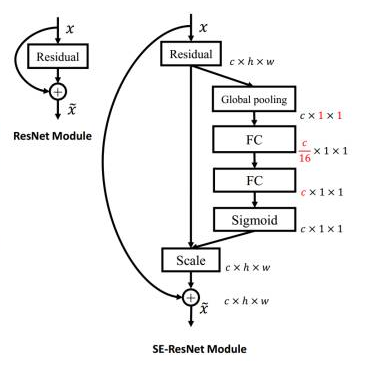

SE-Resnet module其中,global pooling表示全局池化层(将输入的size池化为1 * 1 ), 将c * h * w的输入变为c * 1* 1的输出.FC表示全连接层(线性层),两层FC之间使用ReLU作为激活函数.通过两层FC后使用sigmoid激活函数激活.最后将得到的c个值与原输入c * h * w按channel相乘,得到c * h * w的输出.

补充下方的代码完成SE-Resnet block的实现.

In [131]:
from torch import nn

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        # The output of AdaptiveAvgPool2d is of size H x W, for any input size.
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        #To-Do: add code here
        self.channel = channel
        self.re_channel = channel//reduction
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(channel,self.re_channel)
        self.fc2 = nn.Linear(self.re_channel, channel)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        #To-Do: add code here
        out = self.avg_pool(x)
        out = out.view(-1,self.channel)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        out = out.unsqueeze(2).unsqueeze(2)

        return x * out

In [132]:
class SEResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(SEResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample
        
    def forward(self, x):

        residual = x
        
        #To-Do: add code here
        if self.downsample:
            residual = self.downsample(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out = self.se(out)
        
        out = out + residual
        out = self.relu(out)

        return out

In [133]:
se_resnet = ResNet(SEResidualBlock, [2, 2, 2 ,2])
print(se_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): SEResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
        (relu): ReLU(inplace=True)
        (fc1): Linear(in_features=64, out_features=4, bias=True)
        (fc2): Linear(in_features=4, out_features=64, bias=True)
        (sigmoid): Sigmoid()
      )
    )
    (1): SEResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3

Epoch 1/10:
Step [100/100] Train Loss: 1.4196
Accuracy on Test Set: 36.0800 %
Epoch 2/10:
Step [100/100] Train Loss: 1.6792
Accuracy on Test Set: 30.2200 %
Epoch 3/10:
Step [100/100] Train Loss: 1.6678
Accuracy on Test Set: 43.8600 %
Epoch 4/10:
Step [100/100] Train Loss: 1.4683
Accuracy on Test Set: 49.0400 %
Epoch 5/10:
Step [100/100] Train Loss: 1.1958
Accuracy on Test Set: 50.9200 %
Epoch 6/10:
Step [100/100] Train Loss: 1.2189
Accuracy on Test Set: 53.8400 %
Epoch 7/10:
Step [100/100] Train Loss: 1.1079
Accuracy on Test Set: 52.5400 %
Epoch 8/10:
Step [100/100] Train Loss: 1.0005
Accuracy on Test Set: 59.3000 %
Epoch 9/10:
Step [100/100] Train Loss: 1.1656
Accuracy on Test Set: 60.7000 %
Epoch 10/10:
Step [100/100] Train Loss: 0.7671
Accuracy on Test Set: 60.5400 %


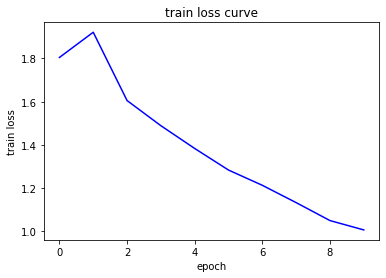

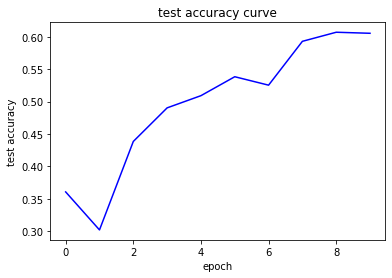

In [134]:
# Hyper-parameters
num_epochs = 10
lr = 0.001
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# optimizer
optimizer = torch.optim.Adam(se_resnet.parameters(), lr=lr)

fit(se_resnet, num_epochs, optimizer, device)